# Impact Assessment of Data Poisoning Attacks on Collaborative Intrusion Detection Systems using Federated Learning

This notebook contains combined figures and analyses that result from the aggregation of our two dataset-specific experiments: over the CIC-CSE-CICIDS2018 and UNSW-NB15 datasets.
The results presented hereafter constitute the core of the 6<sup>th</sup> chapter of my thesis: "Assessing the Impact of Label-Flipping Attacks on FL-based IDSs".

It answers the following research questions:

- **RQ0**: Is the experiment sound?
- **RQ1**: Is the behavior of poisoning attacks predictable?
- **RQ2**: Are there hyperparameter combinations that are beneficial or detrimental in poisoning situation? Do these parameters impact the remediation?
- **RQ3**: At what point do poisoning attacks start having an impact? (proportion of poisoned data/clients)
- **RQ5**: Are backdoor attacks realistic in IDS context?
- **RQ6**: Is model similarity enough to detect poisoning attacks?


In [1]:
%load_ext autoreload
%autoreload 2

from toolbox import init, newfig

init()

SAVEDIR = "/Users/leo/Workspace/phdcybersec/thesis/src/chapters/50_assessment/figures/"


datasets_colors = {
    "cicids": "orange",
    "nb15": "lightskyblue",
}

## RQ1: Is the behavior of poisoning attacks predictable?

Each experiment provides longruns to study the predictability of the poisoning attacks.
Here, we focus highligthing the differences in behaviors between the two.

The line that crosses the graph: nb15/longruns/results/+datasets=nfv2_sampled_nb15,+distribution=5-5,+epochs=300_10x30,+scenario=continuous-100,+target=untargeted,batch_size=512,partitioner=iid,seed=6567


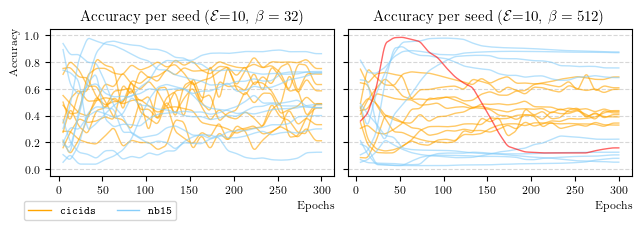

In [2]:
from functools import partial
from pathlib import Path

import numpy as np
import pandas as pd
from eiffel.analysis.metrics import load_metric, search_results
from eiffel.analysis.plot import Plotable, scale
from matplotlib import pyplot as plt
from matplotlib.axes import Axes

load_fn = partial(
    load_metric, dotpath="global.accuracy", attr="distributed", with_malicious=False
)

fig = newfig(format=3 / 1)
axs = fig.subplots(1, 2, sharex=True, sharey="row")


for dataset, color in datasets_colors.items():
    search_fn = partial(
        search_results,
        (Path() / dataset / "longruns/results").as_posix(),
        scenario="continuous-100",
        target="untargeted",
        distribution="5-5",
        datasets=f".*{dataset}",
    )

    for ax, batch_size in zip(axs, [32, 512]):
        ax: Axes
        epochs = 10
        ax.set_title(
            rf"Accuracy per seed ($\mathcal{'{E}'}$={epochs}, $\beta={batch_size}$)",
        )

        accs = scale(
            [
                Plotable(m, load_fn(m))
                for m in search_fn(epochs=f"300_{epochs}x.*", batch_size=batch_size)
            ],
            300,
        )

        # stack the values
        data = np.array([p.values for p in accs])
        x = np.arange(1, len(data[0]) + 1)  # rounds are indexed from 1

        mean = pd.DataFrame(np.mean(data, axis=0), index=x)
        mean = mean.rolling(window=5).mean()[0]
        sigma = np.std(data, axis=0)
        low_sigma = mean - sigma
        high_sigma = mean + sigma
        _min = np.min(data, axis=0)
        _max = np.max(
            data,
            axis=0,
        )
        lines = []
        for acc in accs:
            lines += ax.plot(
                pd.DataFrame(acc.values, index=x).rolling(window=5).mean(),
                alpha=0.6,
                color=color,
                label=acc.name,
            )
        ax.plot([], [], color=color, label=r"\texttt{" f"{dataset}" "}")

        if dataset == "nb15" and batch_size == 512:
            # for l in (l for l in lines if "6567" in l.get_label()):
            #     lines[9].set_color("red")
            lines[9].set_color("red")
            # lines[9].set_alpha(1)
            # lines[9].set_linewidth(2)
            print("The line that crosses the graph:", lines[9].get_label())


for i, ax in enumerate(axs):
    if i == 0:
        ax.set_ylabel("Accuracy", loc="top")

    ax.set_xlabel("Epochs", loc="right")
    ax.set_ylim(-0.05, 1.05)
    ax.grid(axis="y", linestyle="--", alpha=0.5)

handles, labels = ax.get_legend_handles_labels()
handles = [h for h, l in zip(handles, labels) if "datasets" not in l]
labels = [l for l in labels if "datasets" not in l]


lgd = fig.legend(
    handles,
    labels,
    loc="lower left",
    ncol=2,
    frameon=True,
    bbox_to_anchor=(0.02, -0.05),
)

fig.savefig(
    SAVEDIR + "accuracy_per_seed.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight"
)

## RQ2: Do hyperparameters influence the impact of poisoning attacks?

Each experiment provides various hyperparameters combinations. We will study the impact of these hyperparameters on the performance of the model.

For this, we need 3*2 histograms, with side-by-side comparisons of `cicids` and `nb15`:
- 1. Mean accuracy with and without poisoning
- 2. Mean accuracy differnce with and without poisoning
- 3. Mean $\sigma$ difference with and without poisoning

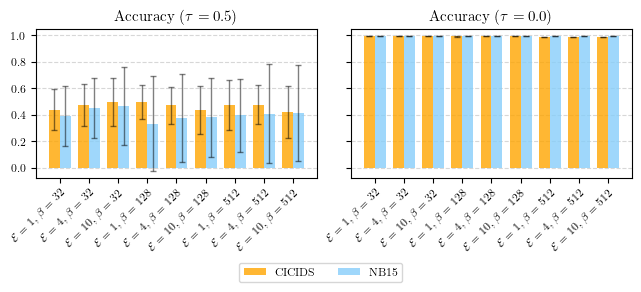

In [3]:
import itertools
from functools import partial

import numpy as np
from eiffel.analysis.metrics import load_df, load_metric, search_results
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure, SubFigure
from matplotlib.lines import Line2D
from matplotlib.ticker import NullFormatter, SymmetricalLogLocator


loadfn = partial(
    load_metric, dotpath="global.accuracy", attr="distributed", with_malicious=False
)


fig = newfig(5 / 2)
axs = fig.subplots(1, 2, sharex=True, sharey=True)

barw = 0.75 / 2  # width of each bar (width / nbars)
bar_kwargs: dict = dict(width=barw, alpha=0.8)
err_kwargs: dict = dict(capsize=2, fmt="none", color="black", linestyle="--", alpha=0.5)

param_tuples = sorted(itertools.product([32, 128, 512], [1, 4, 10]))
labels = [rf"$\mathcal{'{E}'}={e}$, $\beta={b}$" for b, e in param_tuples]
x = np.arange(len(param_tuples))


for ax, dist in zip(axs, ("5-5", "10-0")):
    accuracies: dict[str, list] = {}
    accuracies_std: dict[str, list] = {}

    for dataset, color in datasets_colors.items():
        search_fn = partial(
            search_results,
            (Path() / dataset / "hyperparams/results").as_posix(),
            scenario="continuous-100",
            target="untargeted",
            distribution=dist,
            datasets=f".*{dataset}",
        )

        accuracies[dataset] = []
        accuracies_std[dataset] = []

        for batch_size, epochs in param_tuples:
            df = load_df(
                search_fn(
                    epochs=f".*{epochs}x.*",
                    batch_size=batch_size,
                )
            )

            accuracies[dataset].append(df.mean(axis=0).mean())
            accuracies_std[dataset].append(df.std(axis=0).mean())

    # plot cicids
    ax.bar(
        x=x - barw / 2,
        height=accuracies["cicids"],
        label="CICIDS",
        color=datasets_colors["cicids"],
        **bar_kwargs,
    )
    ax.errorbar(
        x=x - barw / 2,
        y=accuracies["cicids"],
        yerr=accuracies_std["cicids"],
        **err_kwargs,
    )

    # plot nb15
    ax.bar(
        x=x + barw / 2,
        height=accuracies["nb15"],
        label="NB15",
        color=datasets_colors["nb15"],
        **bar_kwargs,
    )
    ax.errorbar(
        x=x + barw / 2,
        y=accuracies["nb15"],
        yerr=accuracies_std["nb15"],
        **err_kwargs,
    )

    ax.set_title(rf"Accuracy ($\tau = 0.{int(dist.split('-')[1])}$)")
    ax.set_xticks(x)
    ax.set_xticklabels(
        labels, rotation=45, ha="right", va="top", rotation_mode="anchor"
    )
    ax.set_yticks(np.linspace(0, 1, 6))
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    ax.set_axisbelow(True)

handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(
    handles,
    labels,
    loc="lower center",
    ncol=2,
    bbox_to_anchor=(0.5, -0.12),
)

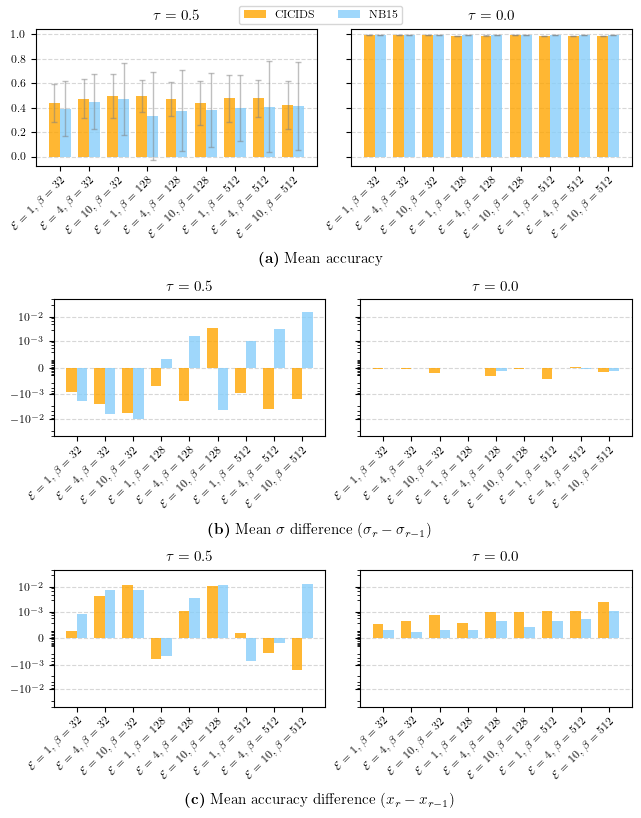

In [41]:
import itertools
from functools import partial

import numpy as np
from eiffel.analysis.metrics import load_df, load_metric, search_results
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure, SubFigure
from matplotlib.lines import Line2D
from matplotlib.ticker import NullFormatter, SymmetricalLogLocator


loadfn = partial(
    load_metric, dotpath="global.accuracy", attr="distributed", with_malicious=False
)


fig = newfig(210 / 260)
subfigures = fig.subfigures(3, 1, hspace=0.12)

barw = 0.75 / 2  # width of each bar (width / nbars)
bar_kwargs: dict = dict(width=barw, alpha=0.8)
err_kwargs: dict = dict(capsize=2, fmt="none", color="gray", linestyle="--", alpha=0.5)

param_tuples = sorted(itertools.product([32, 128, 512], [1, 4, 10]))
labels = [rf"$\mathcal{'{E}'}={e}$, $\beta={b}$" for b, e in param_tuples]
x = np.arange(len(param_tuples))

for i, sub in enumerate(subfigures):
    axs = sub.subplots(1, 2, sharey=True)

    for ax, dist in zip(axs, ("5-5", "10-0")):
        y = {}
        y_err = {}

        for dataset in datasets_colors.keys():
            y[dataset] = []
            y_err[dataset] = []

            for batch_size, epochs in param_tuples:
                df = load_df(
                    search_results(
                        (Path() / dataset / "hyperparams/results").as_posix(),
                        scenario="continuous-100",
                        target="untargeted",
                        distribution=dist,
                        datasets=f".*{dataset}",
                        epochs=f".*{epochs}x.*",
                        batch_size=batch_size,
                    )
                )

                # Round-wise mean and standard deviation
                accs = df.mean(axis=0)
                sigmas = df.std(axis=0)
                diffs = df.diff(axis=1).mean(axis=0)

                # Append metrics
                if i == 0:
                    y[dataset].append(accs.mean())
                    y_err[dataset].append(sigmas.mean())
                elif i == 1:
                    y[dataset].append(diffs.mean())
                    # y_err[dataset].append(diffs.std())
                else:
                    y[dataset].append(sigmas.diff().mean())
                    # y_err[dataset].append(sigmas.diff().std())

        # plot cicids
        ax.bar(
            x=x - barw / 2,
            height=y["cicids"],
            label="CICIDS",
            color=datasets_colors["cicids"],
            **bar_kwargs,
        )
        if any(y_err["cicids"]):
            ax.errorbar(
                x=x - barw / 2,
                y=y["cicids"],
                yerr=y_err["cicids"],
                **err_kwargs,
            )

        # plot nb15
        ax.bar(
            x=x + barw / 2,
            height=y["nb15"],
            label="NB15",
            color=datasets_colors["nb15"],
            **bar_kwargs,
        )
        if any(y_err["nb15"]):
            ax.errorbar(
                x=x + barw / 2,
                y=y["nb15"],
                yerr=y_err["nb15"],
                **err_kwargs,
            )

        ax.set_title(rf"$\tau = {int(dist.split('-')[1])/10}$")
        ax.set_xticks(x)
        ax.set_xticklabels(
            labels, rotation=45, ha="right", va="top", rotation_mode="anchor"
        )
        ax.grid(axis="y", linestyle="--", alpha=0.5)
        ax.set_axisbelow(True)

        if i == 0:
            ax.set_yticks(np.linspace(0, 1, 6))

        else:
            # C = 1 / np.log(10)
            C = 1e-4
            # functions for FuncScale: sgn(x) * log10(1 + abs(x / C))
            logfuncs = (
                lambda x: np.sign(x) * np.log10(1 + np.abs(x / C)),
                lambda y: np.sign(y) * C * (10 ** np.abs(y) - 1),
            )
            ax.set_yscale("function", functions=logfuncs)
            ax.set_yticks([-1e-2, -1e-3, 0, 1e-3, 1e-2])
            ax.set_yticklabels(
                [r"$-10^{-2}$", r"$-10^{-3}$", "0", r"$10^{-3}$", r"$10^{-2}$"]
            )
            y_minor = SymmetricalLogLocator(
                base=10.0, subs=list(np.arange(0.1, 1, 0.2)), linthresh=1e-4
            )
            ax.yaxis.set_minor_locator(y_minor)
            ax.yaxis.set_minor_formatter(NullFormatter())
            ax.set_ylim(-0.05, 0.05)

titles = []
for i, sub in enumerate(subfigures):
    c = chr(ord("a") + i)
    if i == 0:
        titles.append(sub.suptitle(r"\textbf{(%s)} Mean accuracy" % c, y=-0.03))
    elif i == 1:
        titles.append(
            sub.suptitle(
                r"\textbf{(%s)} Mean accuracy difference ($x_{r} - x_{r-1}$)" % c,
                y=-0.03,
            )
        )
    else:
        titles.append(
            sub.suptitle(
                r"\textbf{(%s)} Mean $\sigma$ difference ($\sigma_{r} - \sigma_{r-1}$)"
                % c,
                y=-0.03,
            )
        )

handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(
    handles,
    labels,
    loc="upper center",
    ncol=2,
    # bbox_to_anchor=(0.5, -0.08),
)

fig.savefig(
    SAVEDIR + "hyperparams-continous.pdf",
    bbox_extra_artists=(lgd, *titles),
    bbox_inches="tight",
)